# **Convolutional Neural Networks for EEG**

EEG data is seen as a 2D-array, with the number of time steps as the width, and the number of electrodes as the height (as seen in Figure), EEG data has similar characteristics to an image or audio signal. 

![EEG](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*v13vF7Z79a869hafuVGJzg.png)

Data of nearby timepoints is important for the current datapoint, as well as data from the other channels at the same timepoint. Using convolutions and non-linearities, a CNN can learn local non-linear features and local patterns in these types of data.

Regarding CNNs for EEG data, the most popular models are developed with so-called **temporal and spatial convolutions**.

**A temporal convolution** has a kernel size of 1 x timepoints, where the sliding window will go over each channel with a certain timeframe, and therefore summarizes the EEG data over the timeframe for each channel.

**A spatial convolution** is applied over all channels, for each timepoint, and thus summarizes information over all channels. The convolutions can be applied multiple times with different kernel values, creating different types of summaries of the original data (called feature maps).

![temporal and spatial convolutions](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*9hBPUYQKpIbO0iihrKrxMg.png)

The goal of such convolutions was to represent the CSP pipeline by representing the frequency filtering with temporal convolutions, and spatial filtering with spatial convolutions.

Note:
*Overall, CSP pipelines can greatly enhance the signal-to-noise ratio of EEG signals, improve the accuracy of feature extraction, and facilitate the analysis of EEG data. This can lead to improved performance in various EEG-based applications, and ultimately, contribute to a better understanding of the brain and its functions.*

**Please note** that the original EEGNET differs a bit from our implementation explained here. For example, the authors of the original paper applied the model to **EEG data of 64 electrode channels x 128 timepoints**, while **we used EEG data of 32 electrode channels x 32 timepoints**. 

**In general**, we play around and experiment with the kernel sizes and parameter values when applying the network to our own data.

# **Implementation of EEGNet for 32-channel**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=32, Samples=32):
    # Define the input shape
    input_shape = (Chans, Samples, 1)

    # Define the model architecture
    input_layer = layers.Input(shape=input_shape)

    block1 = layers.Conv2D(16, (1, 32), padding='same', input_shape=input_shape)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.SeparableConv2D(32, (1, 4), use_bias=False, padding='same')(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.MaxPooling2D((1, 4))(block1)
    block1 = layers.Dropout(0.25)(block1)

    block2 = layers.DepthwiseConv2D((1, 4), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.SeparableConv2D(64, (1, 4), use_bias=False, padding='same')(block2)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.MaxPooling2D((1, 2))(block2)
    block2 = layers.Dropout(0.25)(block2)

    flatten = layers.Flatten()(block2)

    dense = layers.Dense(256, activation='elu')(flatten)
    dense = layers.Dropout(0.5)(dense)

    output_layer = layers.Dense(1, activation='sigmoid')(dense)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

This implementation assumes that the EEG data is stored in a NumPy array with shape **(num_trials, num_channels, num_samples)**, and the labels are stored in a NumPy array with shape **(num_trials, num_classes)**

In [ ]:
# # Load and preprocess the EEG data
# data = np.load('eeg_data.npy')
# labels = np.load('eeg_labels.npy')
# data = np.expand_dims(data, axis=3)
# labels = labels[:,0] # Select the first column for binary classification

# # Split the data into training and testing sets
# split = int(0.8 * len(data))
# x_train, y_train = data[:split], labels[:split]
# x_test, y_test = data[split:], labels[split:]

# # Train the model
# model = EEGNet(nb_classes=1)
# history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test))

# # Evaluate the model on the test set
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# Visualize the architecture of the EEGNet network in the form of an image

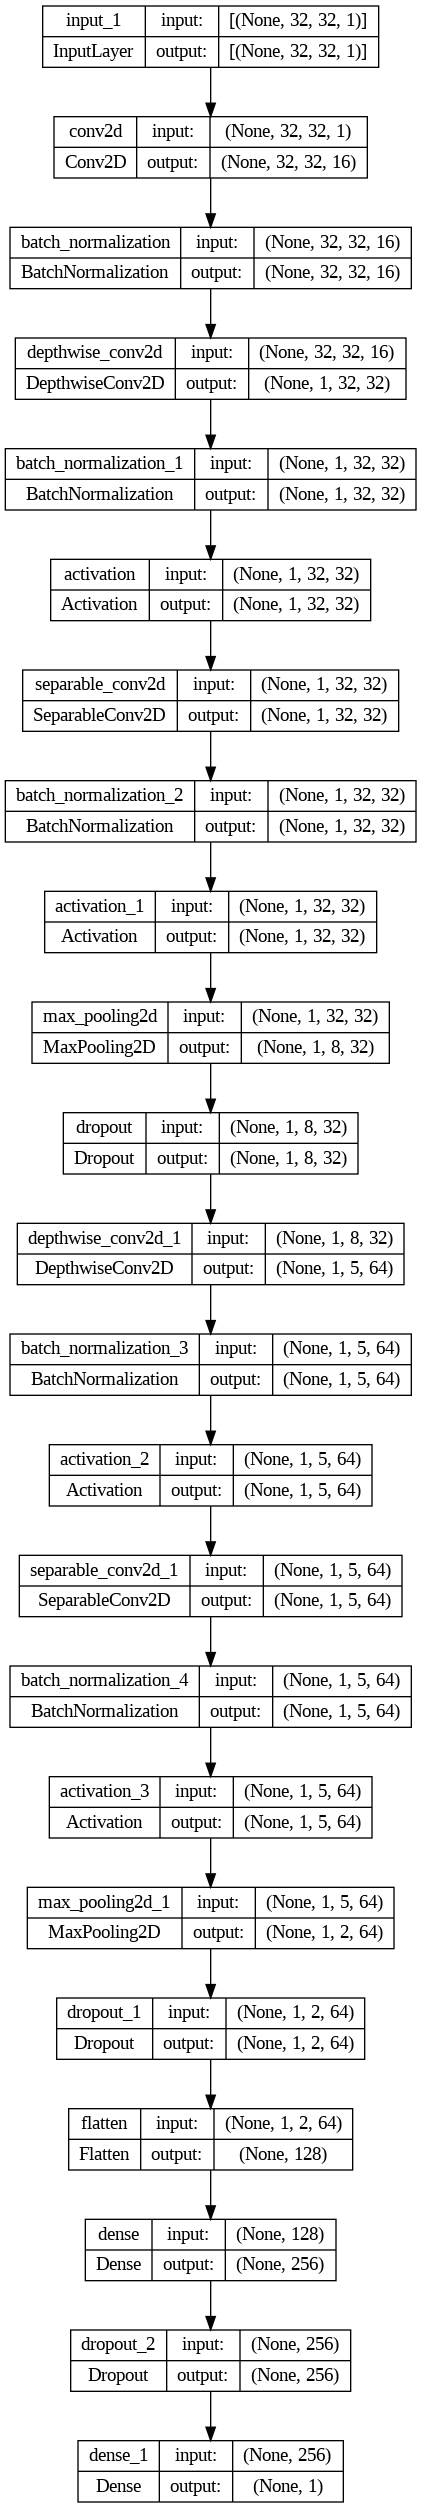

In [2]:
from tensorflow.keras.utils import plot_model
model = EEGNet(nb_classes=1)
plot_model(model, to_file='eegnet_binary.png', show_shapes=True, show_layer_names=True)